# Part 2: Simple Text Processing - Complete Solutions
# Tokenization, Lemmatization, Word Frequency, Vectorization

In [2]:
!pip install spacy
!python -m spacy download en_core_web_sm

  Using cached spacy-3.8.11-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (27 kB)
  Using cached spacy_legacy-3.0.12-py2.py3-none-any.whl.metadata (2.8 kB)
  Using cached spacy_loggers-1.0.5-py3-none-any.whl.metadata (23 kB)
  Using cached murmurhash-1.0.15-cp312-cp312-manylinux1_x86_64.manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_5_x86_64.whl.metadata (2.3 kB)
  Using cached cymem-2.0.13-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (9.7 kB)
  Using cached preshed-3.0.12-cp312-cp312-manylinux1_x86_64.manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_5_x86_64.whl.metadata (2.5 kB)
  Using cached thinc-8.3.10-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (15 kB)
  Using cached wasabi-1.1.3-py3-none-any.whl.metadata (28 kB)
  Using cached srsly-2.5.2-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (19 kB)
  Using cached catalogue-2.0.10-py3-none-any.whl.metadata (14 kB)
  Using cached wea

In [7]:
import spacy
from tqdm import tqdm
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import pickle
from pathlib import Path
nlp = spacy.load("en_core_web_sm")

In [8]:
# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

# Create outputs directory
Path("outputs").mkdir(exist_ok=True)

In [9]:
sotu = pd.read_csv('data/SOTU.csv')  # or whatever your CSV filename is

print(f"Shape: {sotu.shape}")
print(f"Columns: {sotu.columns.tolist()}")

Shape: (246, 4)
Columns: ['President', 'Year', 'Text', 'Word Count']


In [10]:
print(f"\nDataset Overview:")
print(f"  Total speeches: {len(sotu)}")
print(f"  Year range: {sotu['Year'].min()} - {sotu['Year'].max()}")
print(f"  Presidents: {sotu['President'].nunique()}")


Dataset Overview:
  Total speeches: 246
  Year range: 1790.0 - 2024.0
  Presidents: 43


In [11]:
# Display first few rows
print("\nFirst 3 rows:")
print(sotu.head(3))


First 3 rows:
         President    Year                                               Text  \
0  Joseph R. Biden  2024.0  \n[Before speaking, the President presented hi...   
1  Joseph R. Biden  2023.0  \nThe President. Mr. Speaker——\n[At this point...   
2  Joseph R. Biden  2022.0  \nThe President. Thank you all very, very much...   

   Word Count  
0        8003  
1        8978  
2        7539  


In [12]:
# Check data types
print(f"\nData types:")
print(sotu.dtypes)


Data types:
President      object
Year          float64
Text           object
Word Count      int64
dtype: object


In [13]:
# Check for missing values
print(f"\nMissing values:")
print(sotu.isnull().sum())


Missing values:
President     0
Year          0
Text          0
Word Count    0
dtype: int64


In [14]:
# Filter for speeches from 2000 onwards
sotu_2000 = sotu[sotu['Year'] >= 2000].copy()

print(f"\nFiltered dataset:")
print(f"  Original speeches: {len(sotu)}")
print(f"  Speeches from 2000+: {len(sotu_2000)}")
print(f"  Year range: {sotu_2000['Year'].min()} - {sotu_2000['Year'].max()}")


Filtered dataset:
  Original speeches: 246
  Speeches from 2000+: 25
  Year range: 2000.0 - 2024.0


In [15]:
# Show which presidents and years we're analyzing
print(f"\nPresidents in 2000+ dataset:")
president_counts = sotu_2000.groupby('President').size().sort_index()
for president, count in president_counts.items():
    years = sorted(sotu_2000[sotu_2000['President'] == president]['Year'].unique())
    print(f"  {president}: {count} speeches ({min(years)}-{max(years)})")


Presidents in 2000+ dataset:
  Barack Obama: 8 speeches (2009.0-2016.0)
  Donald J. Trump: 4 speeches (2017.0-2020.0)
  George W. Bush: 8 speeches (2001.0-2008.0)
  Joseph R. Biden: 4 speeches (2021.0-2024.0)
  William J. Clinton: 1 speeches (2000.0-2000.0)


In [16]:
# Display first speech to verify
print(f"\nFirst speech preview (2000+):")
print(f"President: {sotu_2000.iloc[0]['President']}")
print(f"Year: {sotu_2000.iloc[0]['Year']}")
print(f"First 200 characters:")
print(sotu_2000.iloc[0]['Text'][:200] + "...")


First speech preview (2000+):
President: Joseph R. Biden
Year: 2024.0
First 200 characters:

[Before speaking, the President presented his prepared remarks to Speaker of the House of Representatives J. Michael Johnson.]
The President. Your bedtime reading.
Tony! Thank you. Looking for Jill.
...


In [17]:
# Process all speeches using nlp.pipe() for efficiency
processed_docs = []

for doc in tqdm(nlp.pipe(sotu_2000['Text'].tolist(), batch_size=50), 
                total=len(sotu_2000), 
                desc="Processing speeches"):
    processed_docs.append(doc)

print(f"\n✓ Processed {len(processed_docs)} speeches")

Processing speeches: 100%|██████████| 25/25 [00:24<00:00,  1.03it/s]


✓ Processed 25 speeches


In [18]:
all_tokens = []

for doc in processed_docs:
    for token in doc:
        if not token.is_stop and not token.is_punct and not token.is_space:
            all_tokens.append(token.text.lower())

token_counts = Counter(all_tokens)
top_25_tokens = token_counts.most_common(25)

print(f"\nTotal tokens: {len(all_tokens):,}")
print(f"Unique tokens: {len(token_counts):,}")
print(f"\nTop 25 Tokens:")
for i, (token, count) in enumerate(top_25_tokens, 1):
    print(f"{i:2d}. ('{token}', {count}),")



Total tokens: 75,983
Unique tokens: 8,948

Top 25 Tokens:
 1. ('america', 816),
 2. ('people', 637),
 3. ('american', 582),
 4. ('new', 530),
 5. ('years', 439),
 6. ('americans', 437),
 7. ('world', 425),
 8. ('year', 406),
 9. ('country', 369),
10. ('jobs', 348),
11. ('tonight', 344),
12. ('work', 324),
13. ('know', 323),
14. ('let', 320),
15. ('congress', 317),
16. ('nation', 311),
17. ('time', 301),
18. ('help', 282),
19. ('need', 266),
20. ('tax', 255),
21. ('president', 247),
22. ('economy', 243),
23. ('like', 241),
24. ('right', 240),
25. ('want', 237),


In [19]:
## Lemma List
all_lemmas = []

for doc in processed_docs:
    for token in doc:
        if not token.is_stop and not token.is_punct and not token.is_space:
            all_lemmas.append(token.lemma_.lower())

lemma_counts = Counter(all_lemmas)
top_25_lemmas = lemma_counts.most_common(25)

print(f"\nTotal lemmas: {len(all_lemmas):,}")
print(f"Unique lemmas: {len(lemma_counts):,}")
print(f"\nTop 25 Lemmas:")
for i, (lemma, count) in enumerate(top_25_lemmas, 1):
    print(f"{i:2d}. ('{lemma}', {count}),")


Total lemmas: 75,983
Unique lemmas: 6,726

Top 25 Lemmas:
 1. ('year', 845),
 2. ('america', 816),
 3. ('people', 639),
 4. ('american', 587),
 5. ('work', 557),
 6. ('new', 532),
 7. ('job', 486),
 8. ('country', 435),
 9. ('americans', 432),
10. ('world', 426),
11. ('know', 395),
12. ('nation', 388),
13. ('help', 378),
14. ('need', 353),
15. ('time', 351),
16. ('tonight', 344),
17. ('child', 332),
18. ('let', 326),
19. ('congress', 317),
20. ('come', 301),
21. ('family', 296),
22. ('good', 294),
23. ('right', 282),
24. ('million', 274),
25. ('want', 264),


In [20]:
print("\n--- Token vs Lemma Comparison ---")

# Compare "year" and "years"
year_count = token_counts.get('year', 0)
years_count = token_counts.get('years', 0)
year_lemma_count = lemma_counts.get('year', 0)

print(f"\nComparison for 'year'/'years':")
print(f"  Token 'year': {year_count}")
print(f"  Token 'years': {years_count}")
print(f"  Lemma 'year': {year_lemma_count}")
print(f"  Note: Lemma combines both forms (expected: {year_count + years_count})")

# Compare "child" and "children"
child_count = token_counts.get('child', 0)
children_count = token_counts.get('children', 0)
child_lemma_count = lemma_counts.get('child', 0)

print(f"\nComparison for 'child'/'children':")
print(f"  Token 'child': {child_count}")
print(f"  Token 'children': {children_count}")
print(f"  Lemma 'child': {child_lemma_count}")
print(f"  Note: Lemmatization groups irregular plurals")


--- Token vs Lemma Comparison ---

Comparison for 'year'/'years':
  Token 'year': 406
  Token 'years': 439
  Lemma 'year': 845
  Note: Lemma combines both forms (expected: 845)

Comparison for 'child'/'children':
  Token 'child': 119
  Token 'children': 215
  Lemma 'child': 332
  Note: Lemmatization groups irregular plurals


In [21]:
def get_most_common_words(df, year, n=25):
    """
    Get the n most common lemmas for a given year.
    
    Parameters:
    -----------
    df : DataFrame
        SOTU dataframe with 'Year' and 'Text' columns
    year : int or float
        Year of interest
    n : int
        Number of top words to return
        
    Returns:
    --------
    list of tuples: (lemma, count) for top n words
    """
    # Subset for the year
    df_year = df[df['Year'] == year]
    
    if len(df_year) == 0:
        print(f"No speeches found for year {year}")
        return []
    
    # Process and extract lemmas
    year_lemmas = []
    for doc in nlp.pipe(df_year['Text'].tolist()):
        for token in doc:
            if not token.is_stop and not token.is_punct and not token.is_space:
                year_lemmas.append(token.lemma_.lower())
    
    # Count and return top n
    return Counter(year_lemmas).most_common(n)

# Test on 2024
print("\n--- Testing function on 2024 ---")
words_2024 = get_most_common_words(sotu, 2024, n=10)
print("\nTop 10 words for 2024:")
print(words_2024)


--- Testing function on 2024 ---

Top 10 words for 2024:
[('president', 58), ('year', 45), ('america', 44), ('american', 34), ('people', 33), ('$', 33), ('member', 32), ('want', 29), ('audience', 29), ('know', 29)]


In [22]:
print("SECTION 4: COMPARE 2023 TO 2017")

# Get top 20 words for each year
words_2023 = get_most_common_words(sotu, 2023, n=20)
words_2017 = get_most_common_words(sotu, 2017, n=20)

print("\nTop 20 words - 2017:")
print(words_2017)

print("\nTop 20 words - 2023:")
print(words_2023)

# Convert to DataFrames
df_2017 = pd.DataFrame(words_2017, columns=['word', 'count'])
df_2023 = pd.DataFrame(words_2023, columns=['word', 'count'])

SECTION 4: COMPARE 2023 TO 2017

Top 20 words - 2017:
[('american', 34), ('america', 29), ('country', 26), ('nation', 21), ('great', 20), ('new', 19), ('year', 19), ('world', 18), ('job', 15), ('people', 15), ('americans', 14), ('united', 13), ('tonight', 13), ('states', 12), ('work', 12), ('child', 12), ('want', 12), ('time', 12), ('citizen', 11), ('right', 11)]

Top 20 words - 2023:
[('year', 58), ('go', 56), ('let', 45), ('know', 40), ('people', 39), ('job', 38), ('america', 36), ('come', 33), ('law', 33), ('pay', 33), ('american', 31), ('$', 31), ('president', 30), ('look', 27), ('world', 25), ('folk', 24), ('nation', 24), ('audience', 23), ('work', 23), ('right', 23)]


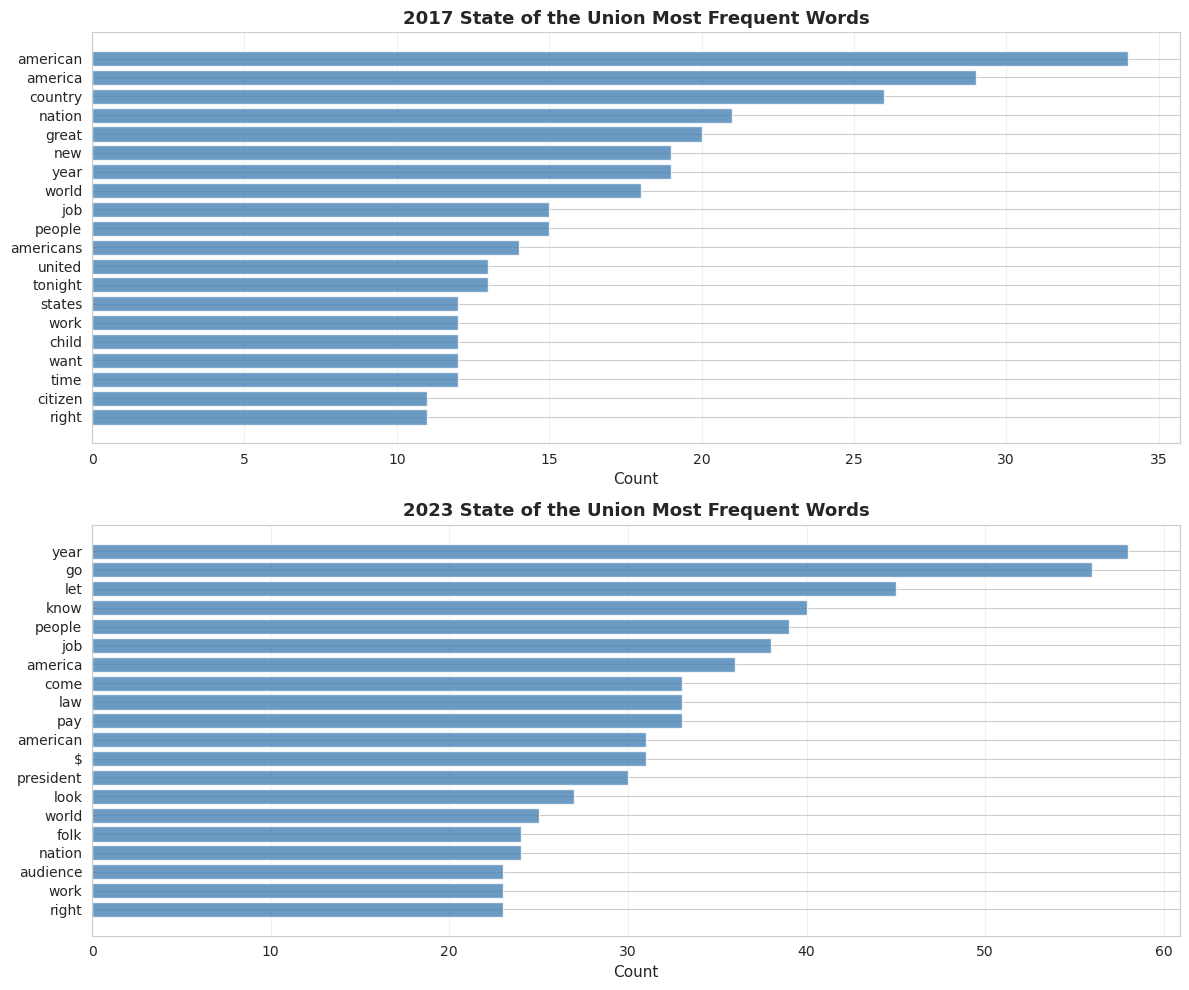

In [20]:
# Visualization
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# 2017 plot
axes[0].barh(range(len(df_2017)), df_2017['count'], color='steelblue', alpha=0.8)
axes[0].set_yticks(range(len(df_2017)))
axes[0].set_yticklabels(df_2017['word'])
axes[0].invert_yaxis()
axes[0].set_xlabel('Count', fontsize=11)
axes[0].set_title('2017 State of the Union Most Frequent Words', 
                   fontsize=13, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# 2023 plot
axes[1].barh(range(len(df_2023)), df_2023['count'], color='steelblue', alpha=0.8)
axes[1].set_yticks(range(len(df_2023)))
axes[1].set_yticklabels(df_2023['word'])
axes[1].invert_yaxis()
axes[1].set_xlabel('Count', fontsize=11)
axes[1].set_title('2023 State of the Union Most Frequent Words', 
                   fontsize=13, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/compare_2017_2023.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Process all speeches
all_processed_docs = []

for doc in tqdm(nlp.pipe(sotu['Text'].tolist(), batch_size=50), 
                total=len(sotu), 
                desc="Processing all speeches"):
    all_processed_docs.append(doc)

print(f"\n✓ Processed {len(all_processed_docs)} speeches")

# Create lemmatized documents from ALL speeches
lemmatized_docs = []

for doc in all_processed_docs:
    lemmas = [token.lemma_.lower() for token in doc 
              if not token.is_stop and not token.is_punct and not token.is_space]
    lemmatized_docs.append(' '.join(lemmas))

print(f"Created {len(lemmatized_docs)} lemmatized documents")

# Train TF-IDF vectorizer on ALL speeches
vectorizer = TfidfVectorizer(
    max_features=1000,
    min_df=2,
    max_df=0.8
)

tfidf_matrix = vectorizer.fit_transform(lemmatized_docs)

print(f"\nTF-IDF Matrix shape: {tfidf_matrix.shape}")
print(f"  Speeches: {tfidf_matrix.shape[0]}")
print(f"  Features: {tfidf_matrix.shape[1]}")

# Save for Part 3
with open('outputs/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

with open('outputs/tfidf_matrix.pkl', 'wb') as f:
    pickle.dump(tfidf_matrix, f)

with open('outputs/lemmatized_docs.pkl', 'wb') as f:
    pickle.dump(lemmatized_docs, f)

print("\n✓ Saved TF-IDF outputs for Part 3")

Processing all speeches:  21%|██        | 51/246 [01:20<04:16,  1.32s/it] 

In [ ]:
# Apply PCA to ALL speeches
pca = PCA(n_components=2)
pca_components = pca.fit_transform(tfidf_matrix.toarray())

print(f"PCA applied to {len(pca_components)} speeches")

# Create plot
fig = plt.figure(figsize=(12, 8))
plt.scatter(pca_components[:, 0], pca_components[:, 1], 
            alpha=0.6, s=50, color='steelblue')
plt.xlabel('Principle Component 1', fontsize=12)
plt.ylabel('Principle Component 2', fontsize=12)
plt.title('Plot of Vectorized Speeches Principle Components', 
          fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)

# Set background color to match expected output
ax = plt.gca()
ax.set_facecolor('#E8E8F0')  # Light purple-gray background

plt.tight_layout()
plt.savefig('outputs/pca_speeches.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nExplained variance:")
print(f"  PC1: {pca.explained_variance_ratio_[0]:.4f}")
print(f"  PC2: {pca.explained_variance_ratio_[1]:.4f}")
print(f"  Total: {pca.explained_variance_ratio_.sum():.4f}")

In [ ]:
print("SECTION 7: HEATMAP VISUALIZATION")
# Convert to dense array
tfidf_dense = tfidf_matrix.toarray()

# Create heatmap
sns.heatmap(tfidf_dense,
            cmap='Reds',
            xticklabels=False,
            yticklabels=range(len(tfidf_dense)),
            norm=plt.matplotlib.colors.LogNorm(),
            cbar_kws={'label': '$10^{-1}$'})

plt.title('Vectorized Speeches', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('outputs/tfidf_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
print("\nGenerated files in outputs/:")
print("  ✓ compare_2017_2023.png")
print("  ✓ pca_speeches.png")
print("  ✓ tfidf_heatmap.png")
print("  ✓ top10_tfidf_scores.csv")
print("  ✓ tfidf_vectorizer.pkl (for Part 3)")
print("  ✓ tfidf_matrix.pkl (for Part 3)")
print("  ✓ lemmatized_docs.pkl (for Part 3)")

print("\nKey findings:")
print(f"  - Processed {len(processed_docs)} speeches from 2000+")
print(f"  - Extracted {len(lemma_counts):,} unique lemmas")
print(f"  - Created {tfidf_matrix.shape[1]}-dimensional TF-IDF vectors")
print(f"  - PCA explains {pca.explained_variance_ratio_.sum():.2%} variance")